In [1]:
import numpy as np
import pandas as pd
import multiprocessing
import scipy
import sklearn as sk
from sklearn import svm

from sklearn import preprocessing
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import clone
from sklearn.externals.six.moves import xrange
from scipy import spatial
from scipy.spatial import cKDTree
#from pyramid.arima import auto_arima

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
# from bokeh import charts

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random


import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da
#from dask import distributed

Loading BokehJS ...

# Wrangling

In [ ]:
%%time
dat0 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

# len(dat0['article_number'].unique()) # 46573

In [ ]:
# Create copy, avoid frequent reloading
dat = dat0.copy()

In [ ]:
dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names

In [ ]:
dat = dat[['article_number', 'gross_demand_quantity', 'sold_qty',
       'net_qty', 'gross_sales_gross_disc_net_ret',
       'gross_sales_net_disc_gross_ret', 'net_sales', 'total_markdown',
       'temporary_markdown', 'permanent_markdown', 'employee_markdown',
       'fraction_of_full_price', 'markdown', 'sale']]

In [ ]:
dat_grouped = dat.groupby(by = 'article_number')

In [ ]:
functions = ['min', 'median', 'mean', 'max', 'std', 'sum', 'count'] # to do: add quantiles back

In [ ]:
%%time
dat = dat_grouped.agg(functions)

In [ ]:
dat['Count'] = dat['sold_qty']['count']

dat.drop('count', level = 1, axis = 1, inplace = True) # # Drop redundant 'count' columns
dat.fillna(value=0, inplace = True) # Define single transaction article std to be 0

# Load curated data

In [60]:
# Save/load tidied version

# dat.to_csv('dat.csv')

dat = pd.read_csv('dat.csv', low_memory=False, index_col = 0, header = [0,1]) # gotta encode multi-index

In [13]:
dat.shape

(46573, 79)

# k-means clustering

In [61]:
%%time

# K-means clustering  --------------------  --------------------
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10)
kmeans.fit(dat)

Kmeans = pd.Series(kmeans.predict(dat)) # Cluster assignments
dat = dat.assign(Kmeans = Kmeans.values) # add to dat

CPU times: user 7.97 s, sys: 128 ms, total: 8.1 s
Wall time: 2.28 s


In [58]:
dat.groupby('Kmeans').count()['sale']['min']
dat['Kmeans'].unique()

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Kmeans
0    37431
1        1
2      148
3       10
4     1717
5       23
6        1
7        7
8      479
9     6756
Name: min, dtype: int64

array([4, 2, 9, 8, 0, 5, 6, 3, 7, 1])

In [ ]:
# Reclassify: majority/non as 0/1 
dat['Kmeans'] = (dat['Kmeans'] == 0)*1 # column
Kmeans = (Kmeans == 0)*1 # lone vector

## k-means plotting

In [63]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'log(net_sales)')

Text(0, 0.5, 'log(sold_qty)')

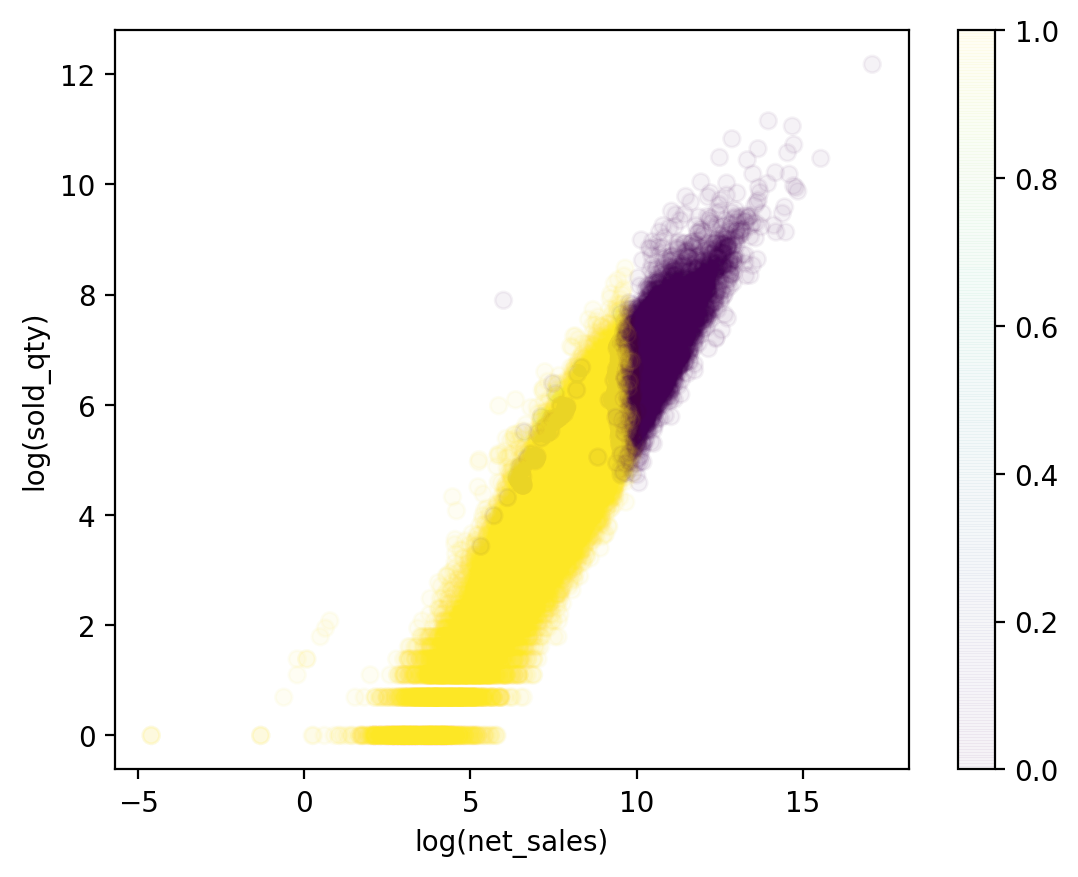

In [66]:
plt.scatter(np.log(dat['net_sales']['sum']), 
            np.log(dat['sold_qty']['sum']), 
            c = dat['Kmeans'],
            alpha = 0.05)
plt.xlabel('log(net_sales)')
plt.ylabel('log(sold_qty)')
plt.colorbar()
# plt.rcParams["figure.figsize"] = [16,16]


In [ ]:
# Scatter matrix??

# Agglomerative Clustering

In [67]:
# Drop k-means classification 
dat.drop('Kmeans', axis = 1, inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [74]:
%%time

# Agglomerative Clustering -------------
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters = 10)
agglom = agg.fit_predict(dat)

CPU times: user 4min 12s, sys: 2min 51s, total: 7min 4s
Wall time: 12min 43s


In [76]:
# agglom = assignment

In [77]:
dat['agglom'] = agglom

# c = pd.Series(kmeans.predict(dat)) # Cluster assignments
# dat = dat.assign(Kmeans = c.values) # add to dat

In [78]:
# Table of cluster counts
dat.groupby('agglom').count()['sale']['min']
dat['agglom'].unique()

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


agglom
0       24
1    41420
2     4001
3      834
4        8
5      225
6        1
7        1
8        7
9       52
Name: min, dtype: int64

array([3, 5, 9, 2, 1, 0, 6, 8, 4, 7])

In [79]:
# Classify as 0/1
dat['agglom'] = (dat['agglom'] == 1)*1


In [ ]:
# Drop outlier for plotting purposes

# dat['net_sales']['sum'][dat['net_sales']['sum'] > 20000000]
# dat.drop('CP9366', inplace = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'log(net_sales)')

Text(0, 0.5, 'log(sold_qty)')

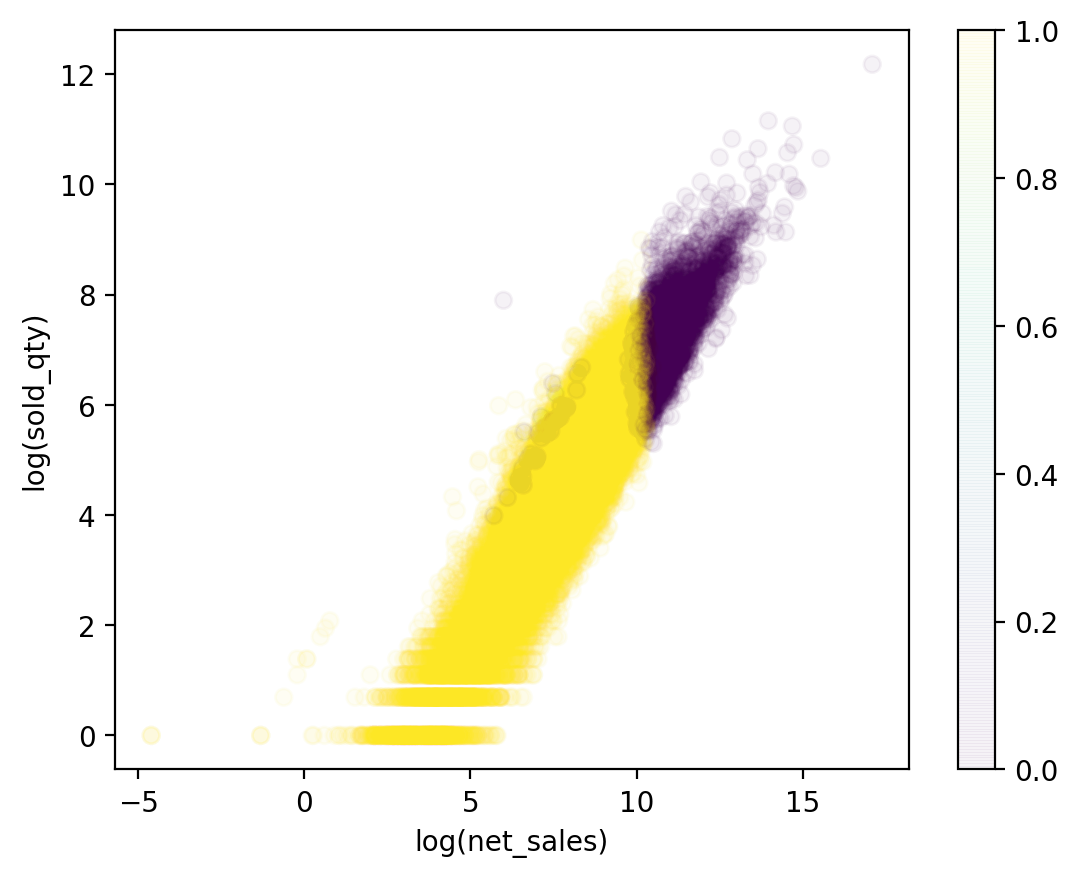

In [81]:
plt.scatter(np.log(dat['net_sales']['sum']), 
            np.log(dat['sold_qty']['sum']), 
            c = dat['agglom'],
            alpha = 0.05)
plt.xlabel('log(net_sales)')
plt.ylabel('log(sold_qty)')
plt.colorbar()

# k-means vs. agglom

# DBSCAN - 'density based spatial clustering of applications with noise'

In [ ]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(dat)